In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
from matplotlib.text import Text

In [259]:
# Get Euros 2024 games
parser = Sbopen()
df_games = parser.match(competition_id=55, season_id=282)
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         51 non-null     int64         
 1   match_date                       51 non-null     datetime64[ns]
 2   kick_off                         51 non-null     datetime64[ns]
 3   home_score                       51 non-null     int64         
 4   away_score                       51 non-null     int64         
 5   match_status                     51 non-null     object        
 6   match_status_360                 51 non-null     object        
 7   last_updated                     51 non-null     datetime64[ns]
 8   last_updated_360                 51 non-null     datetime64[ns]
 9   match_week                       51 non-null     int64         
 10  competition_id                   51 non-null     int64         


In [ ]:
# Look for a game where extra time was played
extra_time_mask = (df_games['home_team_country_name'] == 'England')
df_england = df_games.loc[extra_time_mask, ['match_id', 'match_date', 'home_score', 'away_score', 'home_team_name', 'away_team_name', 'competition_stage_name', 'match_status']]
df_england.head(10)

match_id = 3942227
df = parser.event(match_id)[0]
df_end = df.loc[df['type_name'] == 'Half End', ['period', 'timestamp', 'minute', 'second', 'type_name', 'team_name']]

# Get period times
# Only check for first half, second half and extra time but not for penalties
df_periods = pd.DataFrame(columns=['period', 'length', 'additional_time', 'minutes', 'seconds'])
for period, total_length in [(1, 45), (2, 90), (3, 105), (4, 120)]:
    if period in df_end['period'].values:
        df_end_period = df_end.loc[df_end['period'] == period, ['minute', 'second']].iloc[0]
        period_length = df_end_period['minute'] * 60 + df_end_period['second']
        period_additional_time = period_length - (total_length * 60)

        df_periods = pd.concat([
            df_periods,
            pd.DataFrame([{
                'period': period,
                'length': period_length,
                'additional_time': period_additional_time,
                'minutes': df_end_period['minute'],
                'seconds': df_end_period['second']
            }])
        ], ignore_index=True)
df_periods.head(10)

,period,length,additional_time,minutes,seconds
0,1,2706,6,45,6
1,2,5576,176,92,56
2,3,6300,0,105,0
3,4,7267,67,121,7


In [102]:
def get_dribbles_and_playing_time_df(match_id): 
    df = parser.event(match_id)[0]

    # Get dribbles
    dribbles_mask = (df['type_name'] == 'Dribble')
    df_dribbles = df.loc[dribbles_mask]

    # Get players who made dribbles and init playing time df
    df_playing_time = df_dribbles[['match_id', 'player_name', 'team_name']].drop_duplicates()
    df_playing_time['playing_time'] = 0

    # Get first and second half extra time
    df_end = df[df['type_name'] == 'Half End']
    end_first_half = df_end.iloc[0]['minute'] * 60 + df_end.iloc[0]['second']
    first_half_extra_time = end_first_half - (45 * 60)
    end_second_half = df_end.iloc[-1]['minute'] * 60 + df_end.iloc[-1]['second']
    second_half_extra_time = end_second_half - (90 * 60)
    full_game_time = (90 * 60) + first_half_extra_time + second_half_extra_time

    # Get all substitutions
    subs_mask = (df['type_name'] == 'Substitution')
    df_subs = df.loc[subs_mask, ['type_name', 'period', 'minute', 'second', 'player_name', 'team_name', 'sub_type_name', 'substitution_replacement_name']]

    # Update playing time for players and subs
    for i, player in df_playing_time.iterrows():
        player_name = player['player_name']
        playing_time = 0
        
        # Case 1: Player played the full game (not in any substitution list)
        if player_name not in pd.concat([df_subs['player_name'], df_subs['substitution_replacement_name']]).values:
            playing_time = full_game_time
            
        # Case 2: Player was both subbed in and out
        elif (player_name in df_subs['player_name'].values) and (player_name in df_subs['substitution_replacement_name'].values):
            player_in = df_subs[df_subs['substitution_replacement_name'] == player_name]
            player_out = df_subs[df_subs['player_name'] == player_name]

            # Player was subbed in and out in the same half
            if player_in['period'].iloc[0] == player_out['period'].iloc[0]:
                playing_time = player_out['minute'].iloc[0] * 60 + player_out['second'].iloc[0] - (player_in['minute'].iloc[0] * 60 + player_in['second'].iloc[0])
            
            # Player was subbed in in the first half and out in the second half
            elif player_in['period'].iloc[0] == 1:
                playing_time = (player_out['minute'].iloc[0] * 60 + player_out['second'].iloc[0]) - (player_in['minute'].iloc[0] * 60 + player_in['second'].iloc[0]) + first_half_extra_time
            
        # Case 3: Player was subbed out
        elif player_name in df_subs['player_name'].values:
            player_out = df_subs[df_subs['player_name'] == player_name]
            # Player was subbed out in the first half
            if player_out['period'].iloc[0] == 1:
                playing_time = player_out['minute'].iloc[0] * 60 + player_out['second'].iloc[0]
            
            # Player was subbed out in the second half
            elif player_out['period'].iloc[0] == 2:
                playing_time = first_half_extra_time + (player_out['minute'].iloc[0] * 60 + player_out['second'].iloc[0])


        # Case 4: Player was subbed in and finished the game
        elif player_name in df_subs['substitution_replacement_name'].values:
            player_in = df_subs[df_subs['substitution_replacement_name'] == player_name]

            # Player was subbed in in the first half
            if player_in['period'].iloc[0] == 1:
                playing_time = full_game_time - (player_in['minute'].iloc[0] * 60 + player_in['second'].iloc[0])

            # Player was subbed in in the second half
            elif player_in['period'].iloc[0] == 2:
                playing_time = full_game_time - first_half_extra_time - (player_in['minute'].iloc[0] * 60 + player_in['second'].iloc[0])

        df_playing_time.loc[
            (df_playing_time['match_id'] == match_id) & 
            (df_playing_time['player_name'] == player_name), 
            'playing_time'
        ] = playing_time

    return df_dribbles.reset_index(drop=True), df_playing_time.reset_index(drop=True)

In [103]:
match_id = 3942819
df_test = parser.event(match_id)[0]


,match_id,player_name,team_name,playing_time
0,3942819,Kyle Walker,England,5899
1,3942819,Phil Foden,England,4958
2,3942819,Jude Bellingham,England,5899
3,3942819,Cody Mathès Gakpo,Netherlands,5899
4,3942819,Denzel Dumfries,Netherlands,5752
5,3942819,Xavi Simons,Netherlands,5750
6,3942819,Nathan Aké,Netherlands,5899
7,3942819,Harry Kane,England,4971
8,3942819,Wout Weghorst,Netherlands,3009
9,3942819,Declan Rice,England,5899


In [104]:
# Create empty dribbles dataframe
driblles_columns = ['match_id', 'period', 'minute', 'second', 'type_name', 'outcome_name', 'team_name', 'player_name', 'x', 'y']
df_dribbles = pd.DataFrame(columns=driblles_columns)

# Create empty players dataframe to collect player names and minutes played
players_columns = ['match_id', 'player_name', 'team_name', 'playing_time']
df_players = pd.DataFrame(columns=players_columns)

# Loop through matches
for match_id in df_games['match_id']:
    dribbles_df, playing_time_df = get_dribbles_and_playing_time_df(match_id)

    df_dribbles = pd.concat([df_dribbles, dribbles_df[driblles_columns]], ignore_index=True)
    df_players = pd.concat([df_players, playing_time_df[players_columns]], ignore_index=True)

/var/folders/5d/_v0r0r510wncd2w765n36ksw0000gn/T/ipykernel_57950/1070230682.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dribbles = pd.concat([df_dribbles, dribbles_df[driblles_columns]], ignore_index=True)


In [105]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   match_id      645 non-null    object
 1   player_name   645 non-null    object
 2   team_name     645 non-null    object
 3   playing_time  645 non-null    object
dtypes: object(4)
memory usage: 20.3+ KB


In [106]:
df_dribbles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   match_id      1280 non-null   object 
 1   period        1280 non-null   object 
 2   minute        1280 non-null   object 
 3   second        1280 non-null   object 
 4   type_name     1280 non-null   object 
 5   outcome_name  1280 non-null   object 
 6   team_name     1280 non-null   object 
 7   player_name   1280 non-null   object 
 8   x             1280 non-null   float64
 9   y             1280 non-null   float64
dtypes: float64(2), object(8)
memory usage: 100.1+ KB


In [257]:
# Create player stats: totals of dribbles and playing time
# First, get dribble stats
dribble_stats = df_dribbles.groupby(['player_name', 'team_name', 'outcome_name']).size().unstack(fill_value=0)
dribble_stats = dribble_stats.rename(columns={'Complete': 'complete_dribbles', 'Incomplete': 'incomplete_dribbles'})

# Get total playing time
playing_time_stats = df_players.groupby(['player_name', 'team_name'])['playing_time'].sum().reset_index()
playing_time_stats['minutes_played'] = playing_time_stats['playing_time'] / 60

# Merge the two DataFrames
df_player_stats = pd.merge(playing_time_stats, dribble_stats, on=['player_name', 'team_name'], how='left')

# Calculate minutes played

# Calculate per 90 stats
df_player_stats['total_dribbles'] = df_player_stats['complete_dribbles'] + df_player_stats['incomplete_dribbles']
df_player_stats['dribbles_per_90'] = (df_player_stats['total_dribbles'] / (df_player_stats['playing_time'])) * 5400
df_player_stats['dribble_success_rate'] = df_player_stats['complete_dribbles'] / df_player_stats['total_dribbles']

# Filter out players with less than 100 minutes played and less than 5 dribbles attempted
df_player_stats = df_player_stats[(df_player_stats['playing_time'] > 100) & (df_player_stats['total_dribbles'] > 10)]

# Sort by total dribbles
df_player_stats = df_player_stats.sort_values('dribbles_per_90', ascending=False).reset_index(drop=True)
df_player_stats.head(50)

,player_name,team_name,playing_time,minutes_played,complete_dribbles,incomplete_dribbles,total_dribbles,dribbles_per_90,dribble_success_rate
0,Jeremy Doku,Belgium,19894,331.566667,15,12,27,7.328843,0.555556
1,Khvicha Kvaratskhelia,Georgia,21830,363.833333,14,14,28,6.926248,0.500000
2,Rafael Alexandre Conceição Leão,Portugal,11259,187.650000,6,8,14,6.714628,0.428571
3,Kylian Mbappé Lottin,France,22860,381.000000,18,10,28,6.614173,0.642857
4,Donyell Malen,Netherlands,9351,155.850000,7,4,11,6.352262,0.636364
5,João Pedro Cavaco Cancelo,Portugal,13997,233.283333,9,7,16,6.172751,0.562500
6,Nicholas Williams Arthuer,Spain,31030,517.166667,15,17,32,5.568804,0.468750
7,Dan Ndoye,Switzerland,19309,321.816667,12,7,19,5.313584,0.631579
8,Ousmane Dembélé,France,22516,375.266667,14,8,22,5.276248,0.636364
9,Federico Chiesa,Italy,14378,239.633333,7,6,13,4.882459,0.538462


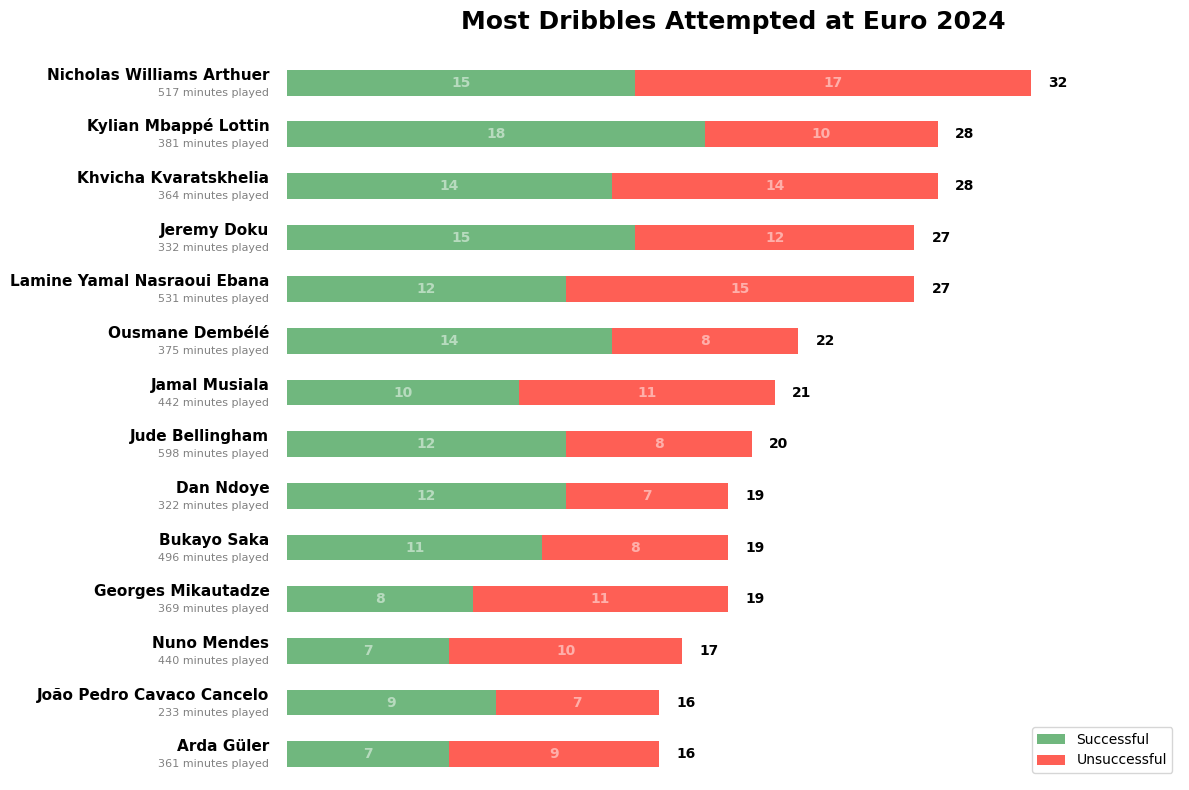

In [256]:
# Plot stacked bars of complete and incomplete dribbles for players with most dribble attempts
df_top_dribblers = df_player_stats[df_player_stats['total_dribbles'] > 15].sort_values(['total_dribbles', 'complete_dribbles'], ascending=True)

# Reset the index after sorting
df_top_dribblers = df_top_dribblers.reset_index(drop=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))


# Set titles and labels
plt.title('Most Dribbles Attempted at Euro 2024', pad=20, fontweight='bold', fontsize=18)
plt.xlabel('Number of dribbles attempted')
plt.ylabel(None)

# Plot stacked bars
df_top_dribblers['complete_dribbles'].plot(kind='barh', color='#70B77E', ax=ax)
df_top_dribblers['incomplete_dribbles'].plot(kind='barh', color='#fe5f55', ax=ax, left=df_top_dribblers['complete_dribbles'])

# Add annotations for complete and incomplete dribbles
for i, v in enumerate(df_top_dribblers['complete_dribbles']):
    ax.text(v/2, i, str(v), 
            color='white',
            alpha=0.5,
            va='center',
            ha='center',
            fontweight='bold')
for i, v in enumerate(df_top_dribblers['incomplete_dribbles']):
    ax.text(v/2 + df_top_dribblers['complete_dribbles'].iloc[i], i, str(v), 
            color='white',
            alpha=0.5,
            va='center',
            ha='center',
            fontweight='bold')

# Add custom player labels using ax.text
for i, row in df_top_dribblers.iterrows():
    # Player name in bold
    ax.text(-0.75, i,
            f"{row['player_name']}", 
            ha='right',
            va='bottom',
            fontsize=11,
            fontweight='bold')
    
    # Minutes in smaller, lighter font
    ax.text(-0.75, i - 0.1,
            f"{row['minutes_played']:.0f} minutes played", 
            ha='right',
            va='top',
            fontsize=8,
            color='gray')

# Add total numbers at the end of each bar
for i, row in df_top_dribblers.iterrows():
    total = row['total_dribbles']
    plt.text(total + 0.75, i, str(int(total)), va='center', fontweight='bold')

# Remove y-axis labels
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])

# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add legend
plt.legend(['Successful', 'Unsuccessful'])

# Adjust layout and margins
plt.margins(x=0.2)
plt.tight_layout()
plt.show()

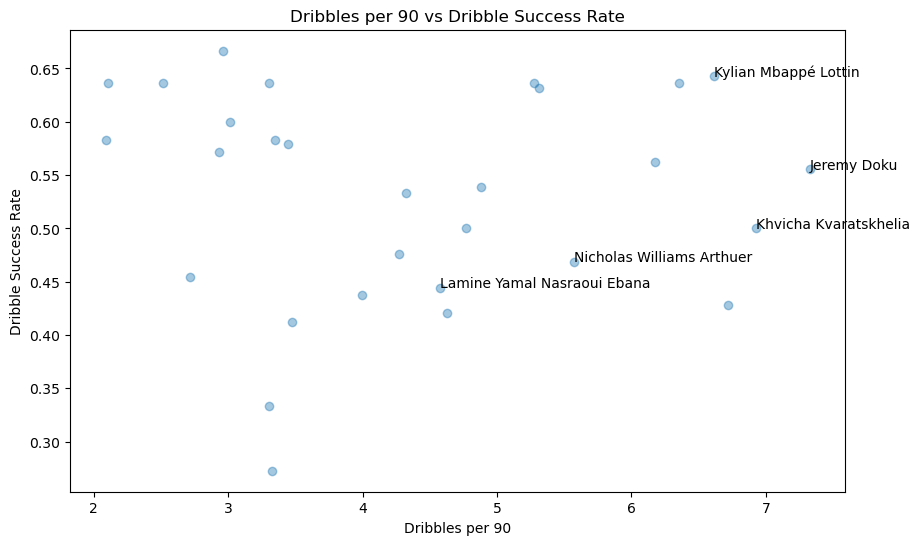

In [137]:
# Scatter plot of dribbles per 90 and dribble success rate
plt.figure(figsize=(10, 6))
plt.scatter(df_player_stats['dribbles_per_90'], df_player_stats['dribble_success_rate'], alpha=0.4)
# add player name to the plot
for i, row in df_player_stats.iterrows():
    if row['total_dribbles'] > 25:
        plt.text(row['dribbles_per_90'], row['dribble_success_rate'], row['player_name'], fontsize=10)
plt.xlabel('Dribbles per 90')
plt.ylabel('Dribble Success Rate')
plt.title('Dribbles per 90 vs Dribble Success Rate')
plt.show()